In [1]:
#Importing required libraries
import numpy as np
import matplotlib.pyplot as mpl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


In [2]:
#Downloading the data
mnist = datasets.fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float32)
y = mnist.target.astype(int)
mask = np.isin(y, [6, 9])
X = X[mask]
y = y[mask]
y = np.where(y == 6, -1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


X_train shape: (11067, 784), y_train shape: (11067,)


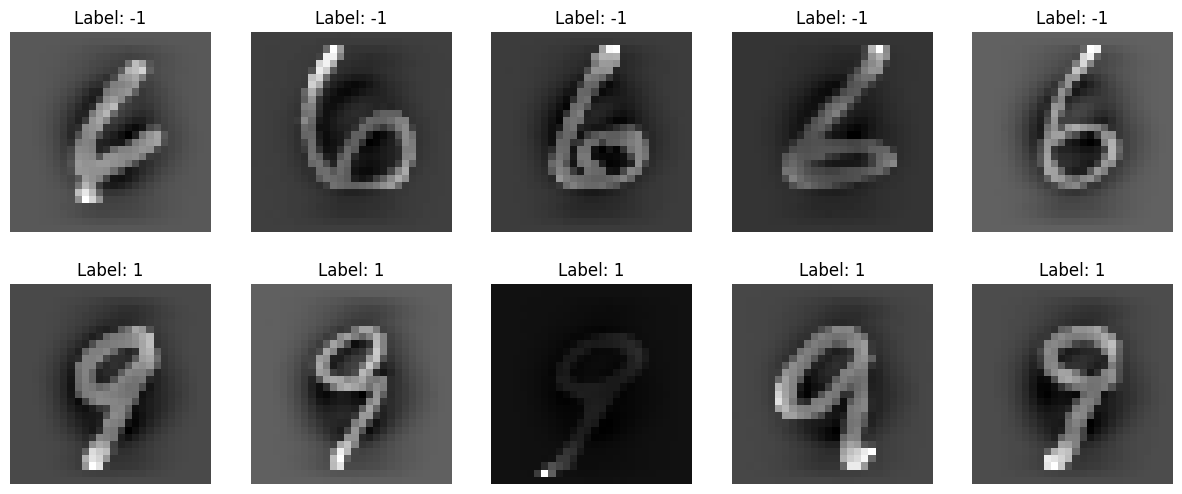

In [11]:
#Displaying sample data
def plot_sample_images(X, y, n_images=5):
    fig, ax = mpl.subplots(2, n_images, figsize=(15, 6))
    for i, label in enumerate([-1, 1]):
        indices = np.where(y == label)[0]
        selected_indices = np.random.choice(indices, size=n_images, replace=False)
        for j, index in enumerate(selected_indices):
            ax[i, j].imshow(X[index].reshape(28, 28), cmap="gray")
            ax[i, j].axis("off")
            ax[i, j].set_title(f"Label: {label}")
    mpl.show()

plot_sample_images(X_scaled, y, n_images=5)


In [13]:
#Calculating Accuracies (Overall, Individual)
def class_accuracies(confusion_matrix):
    true_negative, false_positive = confusion_matrix[0]
    false_negative, true_positive = confusion_matrix[1]
    accuracy_6 = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    accuracy_9 = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    return accuracy_6, accuracy_9

#Log Reg with no regularization
log_reg_no_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
log_reg_no_reg.fit(X_train, y_train)
#Log Reg with regularization
log_reg_with_reg = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
log_reg_with_reg.fit(X_train, y_train)
y_pred_no_reg = log_reg_no_reg.predict(X_test)
y_pred_with_reg = log_reg_with_reg.predict(X_test)
def evaluate_model(model, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=["-1", "1"])
    cm = confusion_matrix(y_true, y_pred)
    acc_6, acc_9 = class_accuracies(cm)
    fpr, tpr, _ = roc_curve(y_true, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    return acc, acc_6, acc_9, report, cm, fpr, tpr, roc_auc

#No Regulariztion
acc_no_reg, acc_6_no_reg, acc_9_no_reg, report_no_reg, cm_no_reg, fpr_no_reg, tpr_no_reg, roc_auc_no_reg = evaluate_model(log_reg_no_reg, y_test, y_pred_no_reg)
#Regularization
acc_with_reg, acc_6_with_reg, acc_9_with_reg, report_with_reg, cm_with_reg, fpr_with_reg, tpr_with_reg, roc_auc_with_reg = evaluate_model(log_reg_with_reg, y_test, y_pred_with_reg)
print("Logistic Regression without Regularization:")
print(f"Accuracy: {acc_no_reg}")
print(f"Accuracy for digit 6: {acc_6_no_reg}")
print(f"Accuracy for digit 9: {acc_9_no_reg}")
print(f"AUROC for Logistic Regression (without regularization): {roc_auc_no_reg:.2f}")
print("---------------------------------------------------------------")
print("Logistic Regression with Regularization:")
print(f"Accuracy: {acc_with_reg}")
print(f"Accuracy for digit 6: {acc_6_with_reg}")
print(f"Accuracy for digit 9: {acc_9_with_reg}")
print(f"AUROC for Logistic Regression (with regularization): {roc_auc_with_reg:.2f}")



Logistic Regression without Regularization:
Accuracy: 0.9981929887965305
Accuracy for digit 6: 0.9992952783650458
Accuracy for digit 9: 0.9992952783650458
AUROC for Logistic Regression (without regularization): 1.00
---------------------------------------------------------------
Logistic Regression with Regularization:
Accuracy: 0.9978315865558366
Accuracy for digit 6: 0.9985905567300916
Accuracy for digit 9: 0.9985905567300916
AUROC for Logistic Regression (with regularization): 1.00


In [5]:
#Implementing SVM (Used RBF kernel)
svm_rbf = SVC(kernel='rbf', gamma='scale', C=1.0, probability=True)
svm_rbf.fit(X_train, y_train)
y_pred_svm = svm_rbf.predict(X_test)
acc_svm, acc_6_svm, acc_9_svm, report_svm, cm_svm, fpr_svm, tpr_svm, roc_auc_svm = evaluate_model(svm_rbf, y_test, y_pred_svm)
print("Kernel SVM (RBF Kernel):")
print(f"Accuracy: {acc_svm}")
print(f"Accuracy for digit 6: {acc_6_svm}")
print(f"Accuracy for digit 9: {acc_9_svm}")
print(f"AUROC for Kernel SVM (RBF Kernel): {roc_auc_svm:.2f}")



Kernel SVM (RBF Kernel):
Accuracy: 0.9953017708709794
Accuracy for digit 6: 0.9922480620155039
Accuracy for digit 9: 0.9922480620155039
AUROC for Kernel SVM (RBF Kernel): 1.00


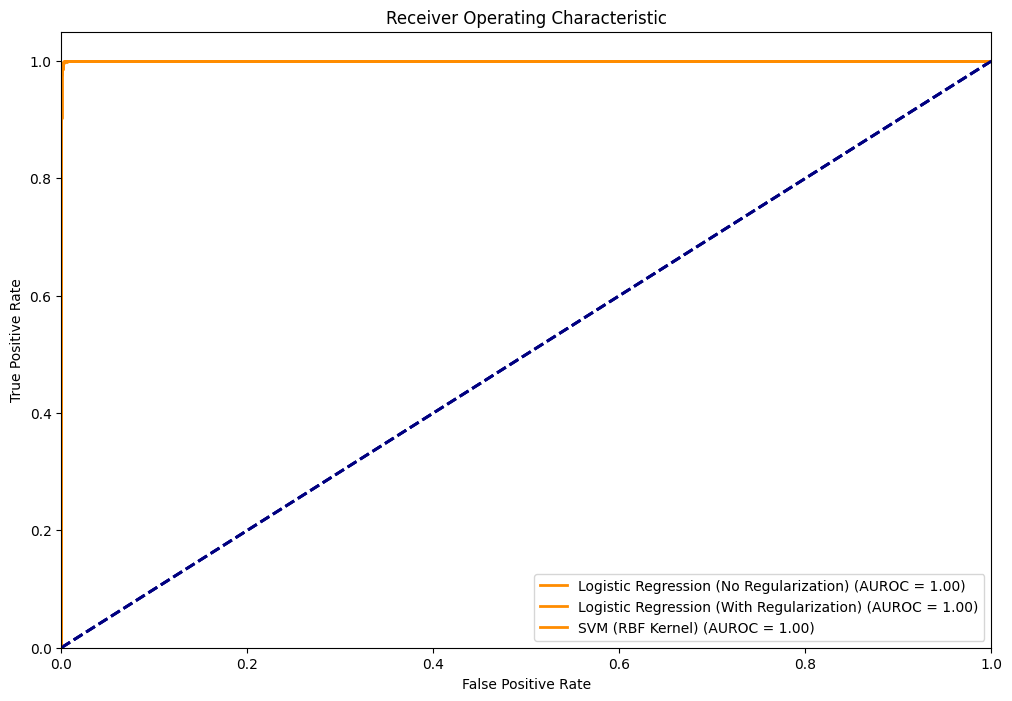

In [6]:
#Plotting the ROC curve for LR no reg, LR Reg, SVM-RBF Kernel)
def plot_roc_curve(fpr, tpr, auc_score, label):
    mpl.plot(fpr, tpr, color='darkorange', lw=2, label=f'{label} (AUROC = {auc_score:.2f})')
    mpl.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    mpl.xlim([0.0, 1.0])
    mpl.ylim([0.0, 1.05])
    mpl.xlabel('False Positive Rate')
    mpl.ylabel('True Positive Rate')
    mpl.title('Receiver Operating Characteristic')
    mpl.legend(loc="lower right")

#No Regularization
fpr_lr_no_reg, tpr_lr_no_reg, _ = roc_curve(y_test, log_reg_no_reg.predict_proba(X_test)[:, 1])
roc_auc_lr_no_reg = auc(fpr_lr_no_reg, tpr_lr_no_reg)
#Regularization
fpr_lr_with_reg, tpr_lr_with_reg, _ = roc_curve(y_test, log_reg_with_reg.predict_proba(X_test)[:, 1])
roc_auc_lr_with_reg = auc(fpr_lr_with_reg, tpr_lr_with_reg)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_rbf.decision_function(X_test))
roc_auc_svm = auc(fpr_svm, tpr_svm)
mpl.figure(figsize=(12, 8))
plot_roc_curve(fpr_lr_no_reg, tpr_lr_no_reg, roc_auc_lr_no_reg, "Logistic Regression (No Regularization)")
plot_roc_curve(fpr_lr_with_reg, tpr_lr_with_reg, roc_auc_lr_with_reg, "Logistic Regression (With Regularization)")
plot_roc_curve(fpr_svm, tpr_svm, roc_auc_svm, "SVM (RBF Kernel)")
mpl.show()


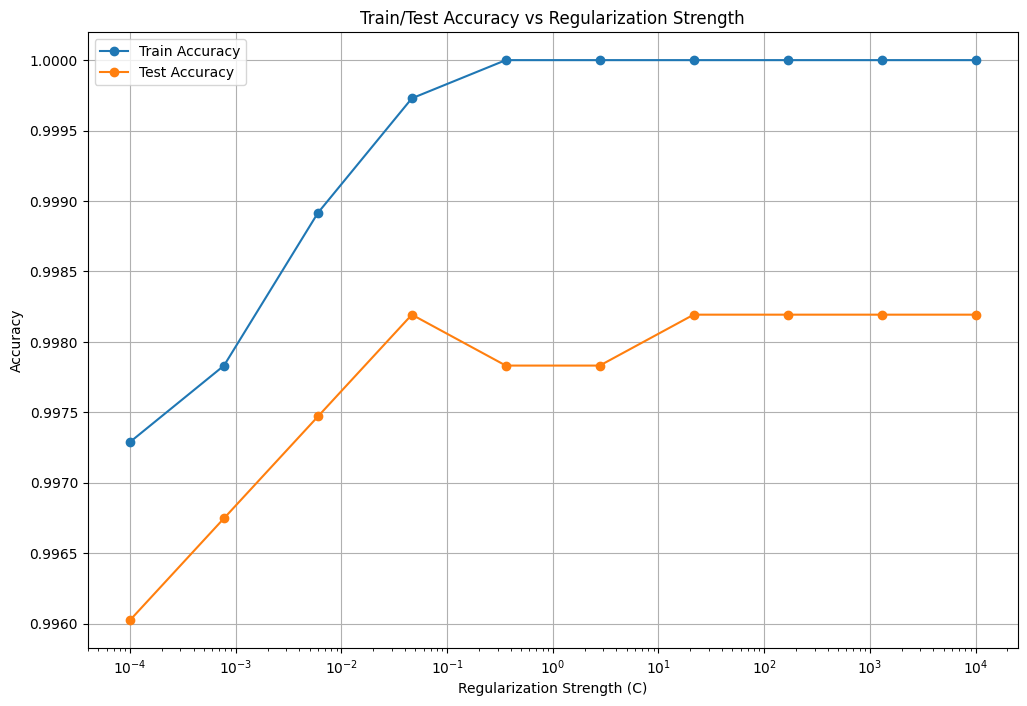

In [7]:
#Plotting the Accuracy vs 1 hyperparameter (I have selected the regularization strength)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
train_acc = []
test_acc = []
C_values = np.logspace(-4, 4, 10)
for C_value in C_values:
    logreg = LogisticRegression(penalty='l2', C=C_value, solver='liblinear', random_state=42)
    logreg.fit(X_train, y_train)
    train_acc.append(logreg.score(X_train, y_train))
    test_acc.append(logreg.score(X_test, y_test))

mpl.figure(figsize=(12, 8))
mpl.semilogx(C_values, train_acc, label='Train Accuracy', marker='o')
mpl.semilogx(C_values, test_acc, label='Test Accuracy', marker='o')
mpl.xlabel('Regularization Strength (C)')
mpl.ylabel('Accuracy')
mpl.title('Train/Test Accuracy vs Regularization Strength')
mpl.legend()
mpl.grid(True)
mpl.show()

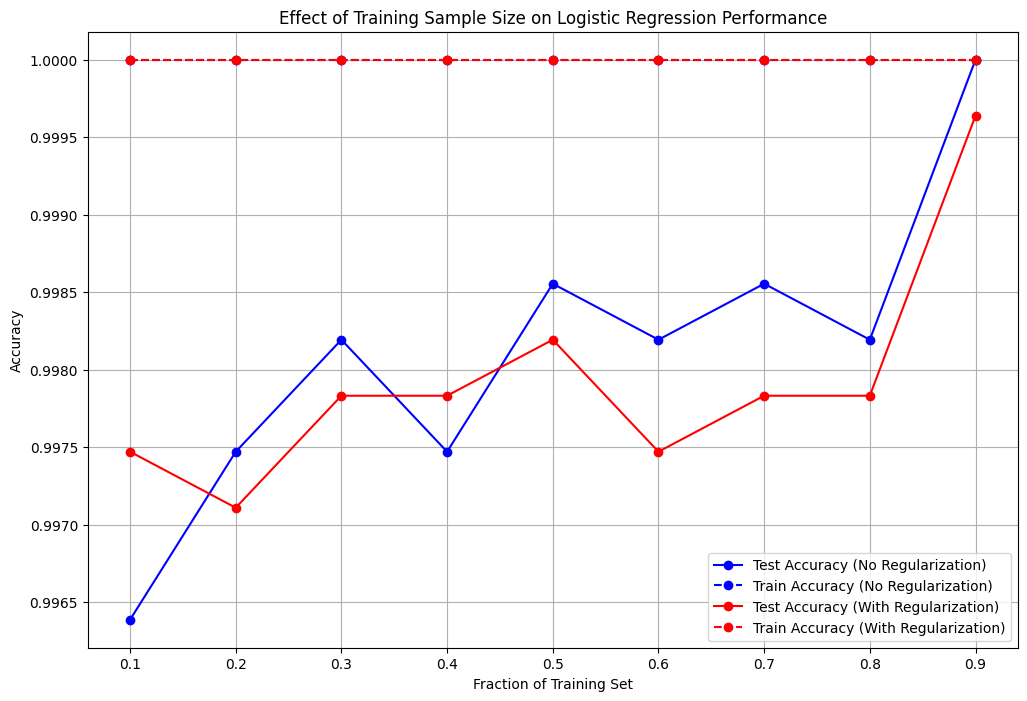

In [8]:
#Plotting the Sample Size plot as asked in the presentation slide (Logistic Regression)
train_sizes = np.linspace(0.1, 0.9, 9)
train_accuracies_no_reg = []
test_accuracies_no_reg = []
train_accuracies_with_reg = []
test_accuracies_with_reg = []
n_samples = X_scaled.shape[0]
for train_size in train_sizes:
    n_train_samples = int(train_size * n_samples)
    X_train_sample, _, y_train_sample, _ = train_test_split(X_scaled, y, train_size=n_train_samples, random_state=42)
    log_reg_no_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
    log_reg_no_reg.fit(X_train_sample, y_train_sample)
    log_reg_with_reg = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
    log_reg_with_reg.fit(X_train_sample, y_train_sample)
    y_pred_no_reg = log_reg_no_reg.predict(X_test)
    y_pred_with_reg = log_reg_with_reg.predict(X_test)
    acc_train_no_reg = accuracy_score(y_train_sample, log_reg_no_reg.predict(X_train_sample))
    acc_test_no_reg = accuracy_score(y_test, y_pred_no_reg)
    acc_train_with_reg = accuracy_score(y_train_sample, log_reg_with_reg.predict(X_train_sample))
    acc_test_with_reg = accuracy_score(y_test, y_pred_with_reg)
    train_accuracies_no_reg.append(acc_train_no_reg)
    test_accuracies_no_reg.append(acc_test_no_reg)
    train_accuracies_with_reg.append(acc_train_with_reg)
    test_accuracies_with_reg.append(acc_test_with_reg)

mpl.figure(figsize=(12, 8))
mpl.plot(train_sizes, test_accuracies_no_reg, label='Test Accuracy (No Regularization)', marker='o', linestyle='-', color='blue')
mpl.plot(train_sizes, train_accuracies_no_reg, label='Train Accuracy (No Regularization)', marker='o', linestyle='--', color='blue')
mpl.plot(train_sizes, test_accuracies_with_reg, label='Test Accuracy (With Regularization)', marker='o', linestyle='-', color='red')
mpl.plot(train_sizes, train_accuracies_with_reg, label='Train Accuracy (With Regularization)', marker='o', linestyle='--', color='red')
mpl.xlabel('Fraction of Training Set')
mpl.ylabel('Accuracy')
mpl.title('Effect of Training Sample Size on Logistic Regression Performance')
mpl.legend(loc='best')
mpl.grid(True)
mpl.show()


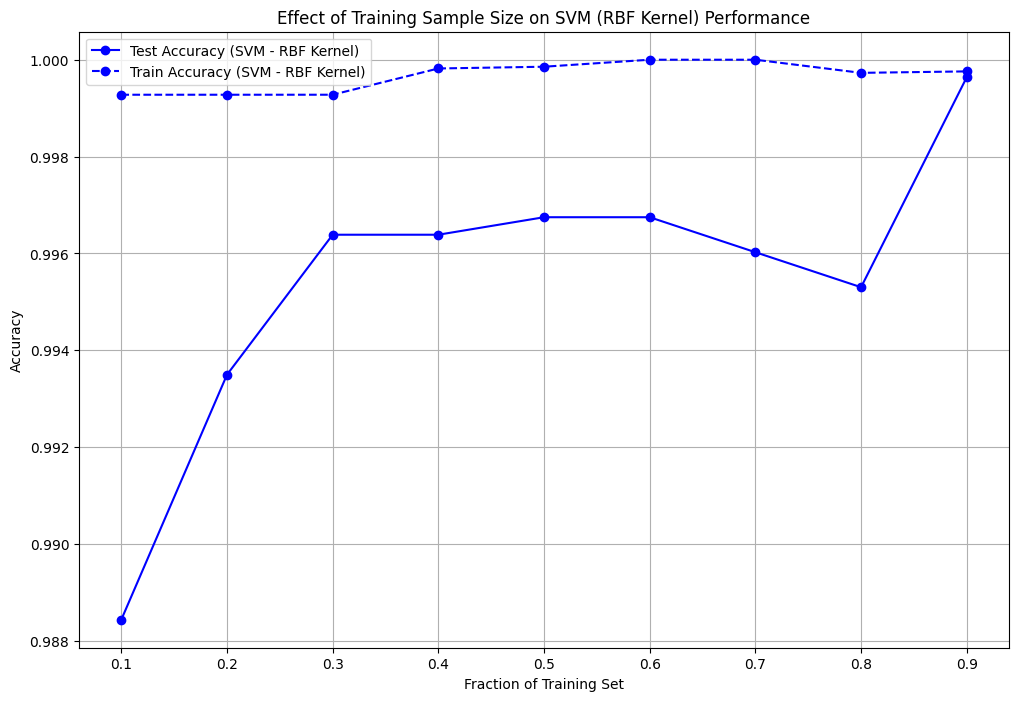

In [9]:
#Plotting the Sample Size plot as asked in the presentation slide (SVM)
train_sizes = np.linspace(0.1, 0.9, 9)
train_accuracies_svm = []
test_accuracies_svm = []
n_samples = X_scaled.shape[0]
for train_size in train_sizes:
    n_train_samples = int(train_size * n_samples)
    X_train_sample, _, y_train_sample, _ = train_test_split(X_scaled, y, train_size=n_train_samples, random_state=42)
    svm_rbf = SVC(kernel='rbf', gamma='scale', C=1.0)
    svm_rbf.fit(X_train_sample, y_train_sample)
    y_pred_svm = svm_rbf.predict(X_test)
    acc_train_svm = accuracy_score(y_train_sample, svm_rbf.predict(X_train_sample))
    acc_test_svm = accuracy_score(y_test, y_pred_svm)
    train_accuracies_svm.append(acc_train_svm)
    test_accuracies_svm.append(acc_test_svm)

mpl.figure(figsize=(12, 8))
mpl.plot(train_sizes, test_accuracies_svm, label='Test Accuracy (SVM - RBF Kernel)', marker='o', linestyle='-', color='blue')
mpl.plot(train_sizes, train_accuracies_svm, label='Train Accuracy (SVM - RBF Kernel)', marker='o', linestyle='--', color='blue')
mpl.xlabel('Fraction of Training Set')
mpl.ylabel('Accuracy')
mpl.title('Effect of Training Sample Size on SVM (RBF Kernel) Performance')
mpl.legend(loc='best')
mpl.grid(True)
mpl.show()


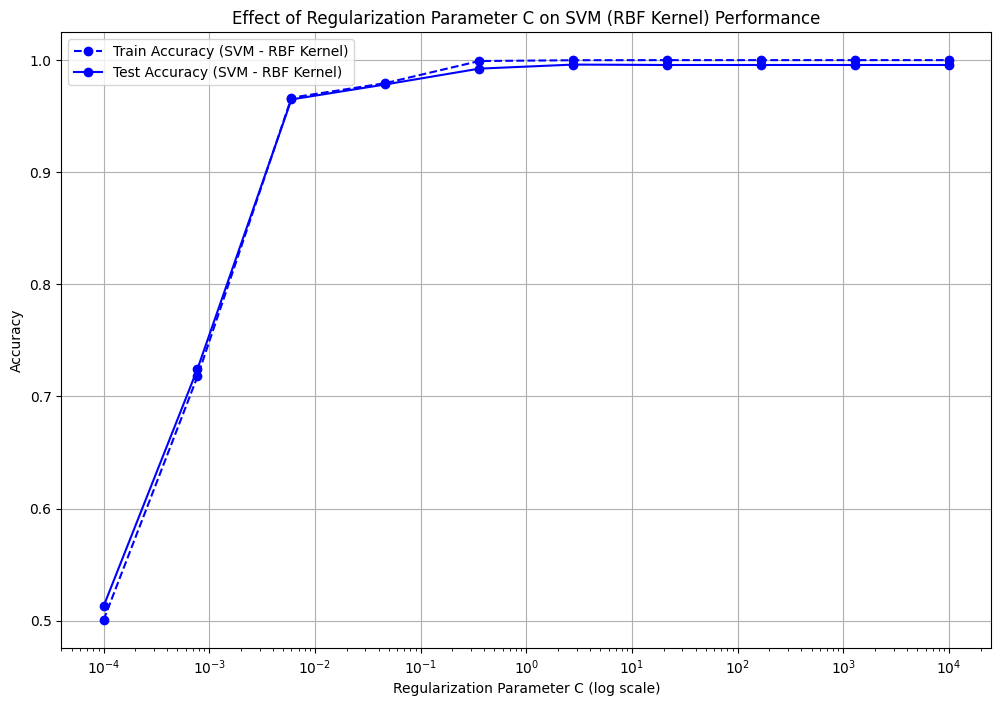

In [10]:
#Plotting the Accuracy vs 1 hyperparameter (I have selected the regularization strength)
C_values = np.logspace(-4, 4, 10)
train_accuracies_svm = []
test_accuracies_svm = []
for C_value in C_values:
    svm_rbf = SVC(kernel='rbf', gamma='scale', C=C_value)
    svm_rbf.fit(X_train, y_train)
    y_pred_svm = svm_rbf.predict(X_test)
    acc_train_svm = accuracy_score(y_train, svm_rbf.predict(X_train))
    acc_test_svm = accuracy_score(y_test, y_pred_svm)
    train_accuracies_svm.append(acc_train_svm)
    test_accuracies_svm.append(acc_test_svm)

mpl.figure(figsize=(12, 8))
mpl.semilogx(C_values, train_accuracies_svm, label='Train Accuracy (SVM - RBF Kernel)', marker='o', linestyle='--', color='blue')
mpl.semilogx(C_values, test_accuracies_svm, label='Test Accuracy (SVM - RBF Kernel)', marker='o', linestyle='-', color='blue')
mpl.xlabel('Regularization Parameter C (log scale)')
mpl.ylabel('Accuracy')
mpl.title('Effect of Regularization Parameter C on SVM (RBF Kernel) Performance')
mpl.legend(loc='best')
mpl.grid(True)
mpl.show()
